# 1. Imports

In [2]:
%matplotlib inline
import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torchvision import transforms
from PIL import Image  #Modificar por rasterio o tifffile
import tifffile as tiff
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from collections import Counter
from sklearn.model_selection import train_test_split



from collections import Counter

from model.tranfAdvModel import SRTransG
from model.discriminatorVITModel import ViTDiscriminator
from model.dataset_manager import load_dataset

#from metrics.imageMetricsSewar import compute_quality_losses,compute_metrics_for_model_dataset
from metrics.imageMetricsTorchMetrics import compute_quality_losses,compute_metrics_for_model_dataset


import pickle
import pyiqa

import time

# 2. Funciones de entrenamiento

In [4]:
# ---------------------------------------------------
# 1. Función para realizar un paso de entrenamiento
# ---------------------------------------------------
def train_step(generator, discriminator, lr_img, hr_img, optimizer_G, optimizer_D,lambda_adv=1e-3, lambda_rec=1, device=None):
    # Generar imagen super-resuelta (SR) a partir de la imagen LR
    sr_img = generator(lr_img)
    
    # Entrenar el Discriminador
    optimizer_D.zero_grad()
    # Upsample de la imagen LR para que coincida con las dimensiones HR
    up_lr = F.interpolate(lr_img, scale_factor=2, mode='bicubic', align_corners=False)
    real_input = torch.cat([up_lr, hr_img], dim=1)  # Concatenar HR real con LR upsampleada -> (B, 6, H, W)
    fake_input = torch.cat([up_lr, sr_img.detach()], dim=1)
    
    real_validity = discriminator(real_input)
    fake_validity = discriminator(fake_input)
    
    valid_labels = torch.ones_like(real_validity)
    fake_labels = torch.zeros_like(fake_validity)
    
    loss_real = F.binary_cross_entropy(real_validity, valid_labels)
    loss_fake = F.binary_cross_entropy(fake_validity, fake_labels)
    loss_D = 0.5 * (loss_real + loss_fake)
    loss_D.backward()
    optimizer_D.step()
    
    # Entrenar el Generador
    optimizer_G.zero_grad()
    fake_input = torch.cat([up_lr, sr_img], dim=1)
    pred_fake = discriminator(fake_input)
    loss_adv = F.binary_cross_entropy(pred_fake, valid_labels)
    loss_rec_dict = compute_quality_losses(pred=sr_img,target=hr_img,data_range=1.0,device=device,use_psnr=True,use_ssim=False)
    loss_rec = loss_rec_dict['psnr_loss']
    #print(f"loss_rec= {loss_rec}")
    loss_G = lambda_adv * loss_adv + lambda_rec * loss_rec
    loss_G.backward()
    optimizer_G.step()
    
    return loss_G.item(), loss_D.item()

In [5]:
# ---------------------------------------------------
# 2. Funcion para entrenar el modelo
# ---------------------------------------------------
def train_model_with_metrics(
    train_loader,
    hr_size,
    num_epochs=2,
    gen_kwargs=None,
    disc_kwargs=None,    
    lr_rate=2e-4,
    model_save_dir=".",
    max_train_time=None,
    start_epoch=-1,
    generator=None,
    discriminator=None,
    optimizer_G=None,
    optimizer_D=None,
    history=None
):
    """
    Entrena el modelo y, al final de cada época, calcula el PSNR y SSIM,
    guarda modelos y detiene el entrenamiento si se supera max_train_time.

    Args:
        train_loader (DataLoader): DataLoader con pares (LR, HR).
        hr_size (tuple[int]): Dimensiones de la imagen HR.
        num_epochs (int): Número máximo de épocas.
        patch_size (int): Tamaño de cada parche.
        imput_dim (int): Número de canales de las imagenes.
        embed_dim (int): Número de canales tras la capa inicial.
        token_dim (int): Dimensión para la proyección de tokens.
        lr_rate (float): Tasa de aprendizaje.
        model_save_dir (str): Directorio donde guardar los pesos del modelo.
        test_count (int): Número de imágenes de prueba a guardar.
        max_train_time (float): Tiempo máximo total de entrenamiento en segundos.

    Returns:
        generator, discriminator, optimizer_G, optimizer_D, history    
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     # 1) Si no se pasan modelos/optimizadores, creamos nuevos
    if generator is None:
        generator = SRTransG(**gen_kwargs).to(device)
    if discriminator is None:
        discriminator = ViTDiscriminator(**disc_kwargs).to(device)
    if optimizer_G is None:
        optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_rate)
    if optimizer_D is None:
        optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_rate)

    # 2) Inicializar historial si es necesario
    if history is None:
        history = {"loss_G": [], "loss_D": [], "PSNR": [], "SSIM": []}
    
    
    generator.train()
    discriminator.train()

    start_total = time.time()
    if start_epoch<0:
        start_epoch=0
        
        
    for epoch in range(start_epoch, num_epochs):                
        epoch_start = time.time()
        
        epoch_loss_G = 0.0
        epoch_loss_D = 0.0
        num_batches = 0
        for lr_imgs, hr_imgs in train_loader:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            loss_G, loss_D = train_step(generator=generator, discriminator=discriminator, lr_img=lr_imgs, hr_img=hr_imgs, optimizer_G=optimizer_G,
                                        optimizer_D=optimizer_D, device=device)
            epoch_loss_G += loss_G
            epoch_loss_D += loss_D
            num_batches += 1
        avg_loss_G = epoch_loss_G / num_batches
        avg_loss_D = epoch_loss_D / num_batches

        #avg_psnr, avg_ssim = evaluate_dataset(generator, train_loader, device)  #Calcular métricas sobre todo el dataset usando el mismo DataLoader

        
        metrics_dict = compute_metrics_for_model_dataset(generator, train_loader, 1.0, device) 
        avg_psnr = metrics_dict["psnr"]
        avg_ssim = metrics_dict["ssim"]
        
        
        history["loss_G"].append(avg_loss_G)
        history["loss_D"].append(avg_loss_D)
        history["PSNR"].append(avg_psnr.item())
        history["SSIM"].append(avg_ssim.item())
        
        elapsed = time.time() - epoch_start
        mins, secs = divmod(int(elapsed), 60)
        total_elapsed = time.time() - start_total
        t_m, t_s = divmod(int(total_elapsed), 60)
        m, s = divmod(int(elapsed), 60)
        print(f"Época {epoch+1}/{num_epochs} - Gen: {avg_loss_G:.4f}, Dis: {avg_loss_D:.4f}, PSNR: {avg_psnr:.2f}dB, SSIM: {avg_ssim:.4f}, "
              f"Tiempos -> Época: {mins}m{secs}s, Total: {t_m}m{t_s}s")
        

        torch.save(generator.state_dict(), model_save_dir+"generator_EP"+ "{:02d}".format(epoch+1)  +".pth")
        #torch.save(discriminator.state_dict(), model_save_dir+"discriminator_EP"+ "{:02d}".format(epoch+1) +".pth")

        # 3) Guardar un checkpoint si se finaliza el entrenamiento por falta de tiempo
        if max_train_time and (time.time() - start_total) > max_train_time:
            print(f"Entrenamiento detenido: tiempo total {time.time() - start_total:.2f}s excede el máximo de {max_train_time}s")
            checkpoint = {
            "epoch": epoch,
            "generator": generator.state_dict(),
            "discriminator": discriminator.state_dict(),
            "opt_G": optimizer_G.state_dict(),
            "opt_D": optimizer_D.state_dict(),
            "history": history,
            "elapsed": elapsed
            }
            torch.save(checkpoint, os.path.join(model_save_dir, "checkpoint.pth"))
            break
        

        generator.train()
    
    return generator, discriminator,optimizer_G,optimizer_D, history, epoch


# 5. Entrenamiento con imagenes satelitales

In [7]:
# ---------------------------------------------------
# 1. Definimos los directorios donde estan los dataset de entrada y los directorios de salida
# ---------------------------------------------------

dataset_dir= "G:/MaestriaInformatica/Tesis/Datasets/"

output_dir= "G:/MaestriaInformatica/Tesis/Outputs_Multilayer/TransfAdv_Sat/"

hr_train_dir = dataset_dir +"SatImages/perusat_v5/HR/"
lr_train_dir = dataset_dir +"SatImages/perusat_v5/LR_BICUBIC/X2/"
suffix = "_x2" 
hr_size=(512,512)
max_images = 400
val_frac = 0.20

sample_test_output_dir = output_dir + "Sat_sample_gen/"
model_save_dir = output_dir + "models/" 

num_epochs = 250 

gen_kwargs = dict(
    input_dim=4,
    embed_dim=16,
    patch_size=16,
    token_dim = 512,
    num_levels=3, 
    num_refinement=1,
    encoder_transformer_blocks=[4,6,6],
    decoder_transformer_blocks=[4,4,6],
    refinement_transformer_blocks=[4]
)

disc_kwargs = dict(
    hr_size=hr_size,
    in_channels=gen_kwargs["input_dim"]*2,
    patch_size=16,
    embed_dim=64,
    depth=6,
    num_heads=4, 
    mlp_ratio=4
)

lr_rate = 4e-5
initial_lr_rate = 1e-3
minimum_lr_rate = 1e-6

if not(os.path.exists(model_save_dir)):
    os.makedirs(model_save_dir, exist_ok = True)

if not(os.path.exists(sample_test_output_dir)):
    os.makedirs(sample_test_output_dir, exist_ok = True)

In [8]:
# ---------------------------------------------------
# 2. Configuración del DataLoader
# ---------------------------------------------------
# archivo donde está definido el split train-val del dataset
splits_pkl = os.path.join(model_save_dir, "splits.pkl")
#cargamos el dataset
train_dataset, val_dataset, train_hr, val_hr, _ = load_dataset(hr_train_dir, lr_train_dir, suffix=suffix, max_images=max_images, hr_size=hr_size, val_frac=val_frac, pickle_path=splits_pkl)

# Crear DataLoader (batch size pequeño para ahorrar memoria)
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

lr_all, hr_all = train_loader.dataset.tensors

print("Dataset HR (CPU):", hr_all.shape)
print("Dataset LR (CPU):", lr_all.shape)

Dataset HR (CPU): torch.Size([320, 4, 512, 512])
Dataset LR (CPU): torch.Size([320, 4, 256, 256])


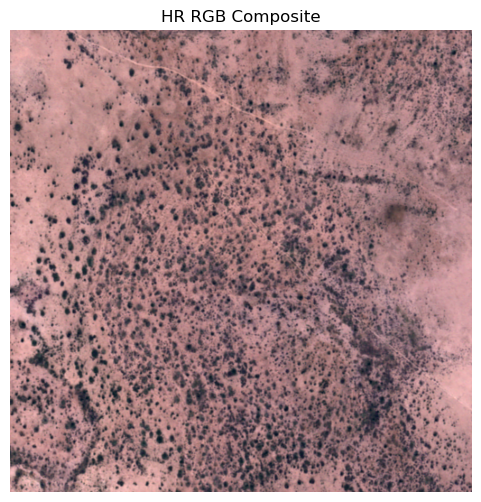

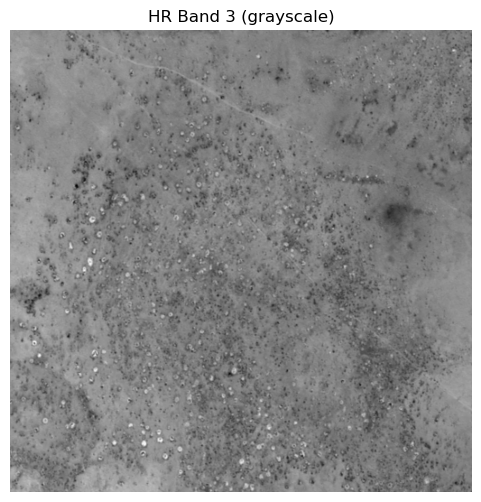

In [9]:
# Get one batch (since batch_size=1, this is one sample)
lr_batch, hr_batch = next(iter(train_loader))
# hr_batch has shape (1, C, H, W); remove batch dim:
hr = hr_batch[0].cpu().numpy()  # shape (C, H, W)

# If you also want the LR:
# lr = lr_batch[0].cpu().numpy()

# 1) Plot the true-color RGB composite (channels 0,1,2)
if hr.shape[0] >= 3:
    rgb = hr[:3, :, :].transpose(1, 2, 0)  # H x W x 3
    # Normalize to [0,1] for display (if needed)
    rgb_min, rgb_max = rgb.min(), rgb.max()
    rgb = (rgb - rgb_min) / (rgb_max - rgb_min + 1e-6)
    plt.figure(figsize=(6,6))
    plt.title("HR RGB Composite")
    plt.imshow(rgb)
    plt.axis('off')
else:
    print("Not enough bands for RGB composite (need ≥3 channels).")

# 2) Plot each additional band in grayscale
n_bands = hr.shape[0]
for c in range(3, n_bands):
    band = hr[c, :, :]
    plt.figure(figsize=(6,6))
    plt.title(f"HR Band {c} (grayscale)")
    plt.imshow(band, cmap='gray')
    plt.axis('off')

plt.show()

In [10]:
# ---------------------------------------------------
# 3. Entremiento del modelo
# ---------------------------------------------------

checkpoint_path = os.path.join(model_save_dir, "checkpoint.pth")

if os.path.exists(checkpoint_path):
    print("Checkpoint encontrado: reanudando entrenamiento.")
    ckpt = torch.load(checkpoint_path, map_location="cpu")
    start_epoch = ckpt["epoch"] + 1
    history = ckpt["history"]
    elapsed_prev = ckpt["elapsed"]
     # Recrear modelos y optimizadores
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    generator = SRTransG(**gen_kwargs).to(device)
    discriminator = ViTDiscriminator(**disc_kwargs).to(device)
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4)

    # Cargar estados
    generator.load_state_dict(ckpt["generator"])
    discriminator.load_state_dict(ckpt["discriminator"])
    optimizer_G.load_state_dict(ckpt["opt_G"])
    optimizer_D.load_state_dict(ckpt["opt_D"])

else: 
    print("Sin checkpoint: comenzando desde cero.")
    start_epoch = -1
    history = None
    elapsed_prev = 0.0
    generator = discriminator = optimizer_G = optimizer_D = None
    
# Iniciamos el entrenamiento
generator, discriminator, optimizer_G, optimizer_D, history, last_epoch = train_model_with_metrics(
    train_loader,
    hr_size,
    num_epochs=num_epochs,
    gen_kwargs = gen_kwargs,
    disc_kwargs = disc_kwargs,   
    lr_rate=lr_rate,
    model_save_dir=model_save_dir,
    max_train_time = 7200,
    start_epoch=start_epoch,
    generator=generator,
    discriminator=discriminator,
    optimizer_G=optimizer_G,
    optimizer_D=optimizer_D,
    history=history)


#guardamos la lista de nombres de las imagenes que estan en el grupo de entrenamiento y las del grupo de validaciónn
with open( model_save_dir+"splits.pkl", "wb") as f:
    pickle.dump({"train": train_hr, "val": val_hr}, f)

#guardamos el historial de looses, PSNR y SSIM
with open( model_save_dir+"history.pkl", "wb") as f:
    pickle.dump({"history": history}, f)

# guardamos los modelos
os.makedirs(model_save_dir, exist_ok = True) 
torch.save(generator.state_dict(), model_save_dir+"generator.pth")
torch.save(discriminator.state_dict(), model_save_dir+"discriminator.pth")

Sin checkpoint: comenzando desde cero.


G:\anaconda3\Lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(


OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacity of 23.99 GiB of which 0 bytes is free. Of the allocated memory 37.51 GiB is allocated by PyTorch, and 41.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# 6. Metricas y ejemplos

In [ ]:
# ---------------------------------------------------
# 3. Evaluación: Mostramos la evolución de nuestros indicadores
# ---------------------------------------------------
epochs = range(1, len(history["loss_G"]) + 1)

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(epochs, history["loss_G"], label="Pérdida Generador", marker="o")
plt.plot(epochs, history["loss_D"], label="Pérdida Discriminador", marker="o")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Historial de Pérdidas")
plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs, history["PSNR"], label="PSNR", marker="o", color="green")
plt.xlabel("Época")
plt.ylabel("PSNR (dB)")
plt.title("Historial de PSNR")
plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs, history["SSIM"], label="SSIM", marker="o", color="red")
plt.xlabel("Época")
plt.ylabel("SSIM")
plt.title("Historial de SSIM")
plt.legend()

plt.tight_layout()
plt.show()